In [1]:
import pandas as pd
import numpy as np
import math
import time
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import constant
import tools
import myplot
import features
from models import MLP, train_model, timeseries_kfold_validation_training, Evaluation

# 1. Load Files

In [2]:
# settlement = pd.read_parquet(constant.settlement_2018_path)
settlement = pd.read_parquet(constant.settlement_2019_path)
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
# windmill = pd.read_csv(constant.windmill_SC1_path, dtype=dtype)
windmill = pd.read_csv(constant.windmill_SC1_path, dtype=dtype).sample(n=10, random_state=1)

wu10 = pd.read_parquet(constant.wu10_path)
wv10 = pd.read_parquet(constant.wv10_path)
wu100 = pd.read_parquet(constant.wu100_path)
wv100 = pd.read_parquet(constant.wv100_path)

ws10 = pd.read_parquet(constant.ws10_path)
ws100 = pd.read_parquet(constant.ws100_path)

tmp2 = pd.read_parquet(constant.tmp2_path)
tmp100 = pd.read_parquet(constant.tmp100_path)

### Aggregate windmill and settlement

In [3]:
df = pd.merge(windmill, settlement, on="GSRN")

# 2. Feature Extraction

In [4]:
features.fun_register(wu10, wv10, wu100, wv100, tmp2, tmp100)

In [8]:
df = features.parallelize_extract(df)

362.4533109664917


In [11]:
temp = df.copy()

In [15]:
cols_filter = ["grid", "month", "hour", "GSRN", "Turbine_type", "Placement", "Rotor_diameter", "Navhub_height", "Roughness", "Parent_GSRN", "BBR_municipal", "Capacity_kw", "TIME_CET", "predicted_ahead", 'UTM_x', 'UTM_y']

In [20]:
cols = [x for x in df.columns if x not in cols_filter]
df[cols] = tools.normalize_maxmin(df[cols])

In [21]:
df["TIME_CET"] = pd.to_datetime(df["TIME_CET"])

In [27]:
windmill["GSRN"].values

array(['570715000000017858', '570715000000053382', '570715000000002533',
       '570715000000012723', '570715000000034060', '570715000000002564',
       '570715000000046377', '570715000000034183', '570715000000046407',
       '570715000000046735'], dtype=object)

In [28]:
date_s = pd.to_datetime("2019-12-05")
date_e = pd.to_datetime("2019-12-06")
df_train = df[df["TIME_CET"] < date_s].sort_values(["GSRN", "TIME_CET"]).reset_index(drop=True)

df_evl = df[df["TIME_CET"] >= date_s][df["TIME_CET"] < date_e][df["GSRN"]=="570715000000017858"].sort_values(["TIME_CET"]).reset_index(drop=True)

# Prediction NN - Geo Free

In [153]:
cols = ['hws_u_wsr','hws_v_wsr','hws_uv_wsr','hws_uv_wsr^2','hws_uv_wsr^3','htmp_exp',
'hws_uv_wsr_q0.1','hws_uv_wsr_q0.3','hws_uv_wsr_q0.5','hws_uv_wsr_q0.7','hws_uv_wsr_q0.9',
'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']

In [24]:
model_geofree = MLP(
  input_size=47,
  hidden_size=1000,
  output_size=1
)
model_geofree, train_hist_geofree, test_hist_geofree = timeseries_kfold_validation_training(df=df_train, features=cols, target=["VAERDI"], n_groups=2, model=model_geofree, lr=0.001, num_epochs=30)

Epoch 0 train loss: 0.052697569131851196 test loss: 0.031465668231248856
Epoch 10 train loss: 0.025392698124051094 test loss: 0.018674790859222412
Epoch 20 train loss: 0.019407978281378746 test loss: 0.016172517091035843
Epoch 29 train loss: 0.013879816979169846 test loss: 0.011671741493046284


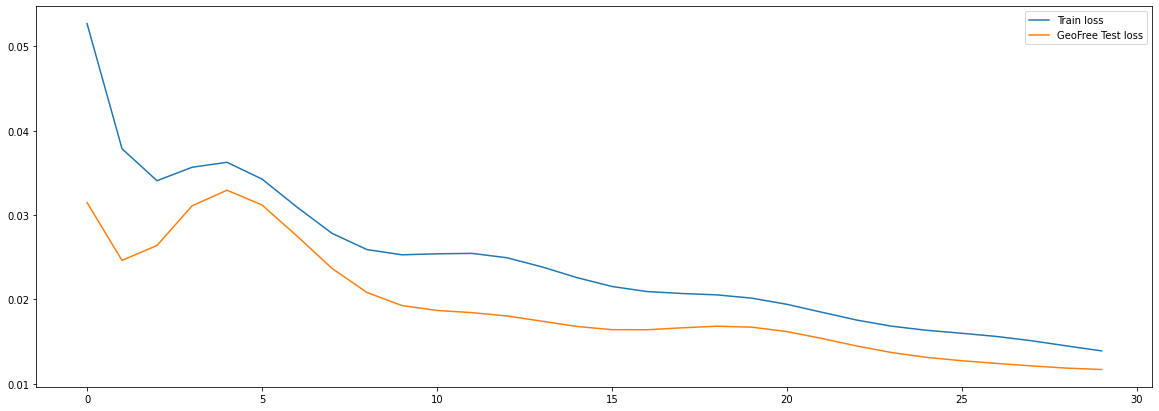

In [25]:
myplot.Model_Loss({"Train loss":train_hist_geofree, "GeoFree Test loss": test_hist_geofree})

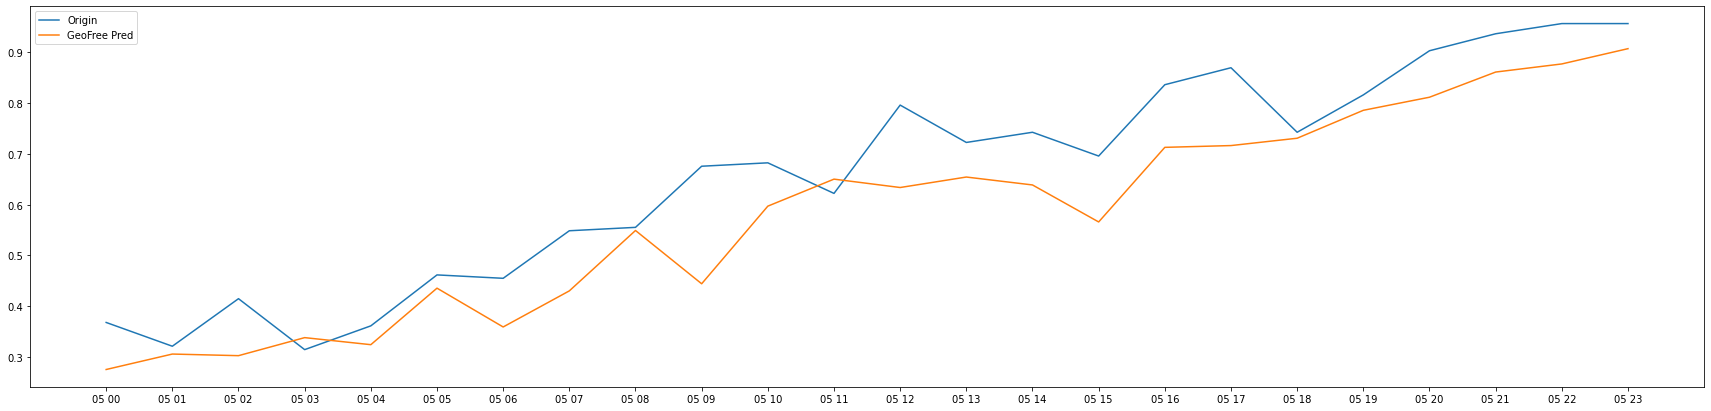

In [154]:
x_test_tensor = torch.tensor(df_evl[cols].values, dtype = torch.float)
y_pred_tensor = model_geofree(x_test_tensor)
df_evl["pred"] = y_pred_tensor.detach().flatten().numpy()

myplot.timelines_plot(df_evl["TIME_CET"], {"Origin": df_evl["VAERDI"], "GeoFree Pred":df_evl["pred"]})

In [ ]:
df_evl["pred"] = y_pred_tensor.detach().flatten().numpy()
myplot.timelines_plot(df_evl["TIME_CET"], {"Origin": df_evl["VAERDI"], "GeoFree Pred":df_evl["pred"]})

### Evaluation by test
BIAS, MAE, MSE, RMSE

In [155]:
from sklearn.metrics import r2_score
def Evaluation(df, name):
    df = df.reset_index(drop = True)
    df = df.reset_index()
    N = len(df)
    df["index"] = df["index"] + 1

    bias = df["VAERDI"] - df["pred"]

    df["VAERDI_cumsum"] = df["VAERDI"].cumsum()
    df[name+"_NBIAS"] = (bias).cumsum() / df["VAERDI_cumsum"]
    df[name+"_NMAE"] = (abs(bias)).cumsum() / df["VAERDI_cumsum"]
    df[name+"_NMSE"] = ((abs(bias)).cumsum() ** 2) / df["VAERDI_cumsum"]
    df[name+"_NRMSE"] = ((((abs(bias)).cumsum() ** 2) * N) ** 0.5 ) / df["VAERDI_cumsum"] 
    # df[name+"_NSDE"] = (  (bias - bias / df["index"]).cumsum() ** 2 / (N - df["index"] + 1)  ) ** 0.5  / (df["VAERDI_cumsum"] / df["index"])
    
    df[name+"_R^2"] = [r2_score(df["VAERDI"][:i+1], df["pred"][:i+1]) for i in range(len(df))]

    timelines_plot(df["TIME_CET"], 
            {name+"BIAS": df[name+"_NBIAS"], 
            name+"MAE":df[name+"_NMAE"],
            name+"MSE":df[name+"_NMSE"],
            name+"RMSE":df[name+"_NRMSE"]})
    df = df.drop(["index"], axis=1)

    return df

In [156]:
def timelines_plot(time, ys):
    time = time.apply(str)
    plt.figure(figsize=(30,7))
    for label, th in ys.items():
        plt.plot(time.apply(lambda x: x[-11:-6]), th, label=label)
    plt.legend()
    plt.show()

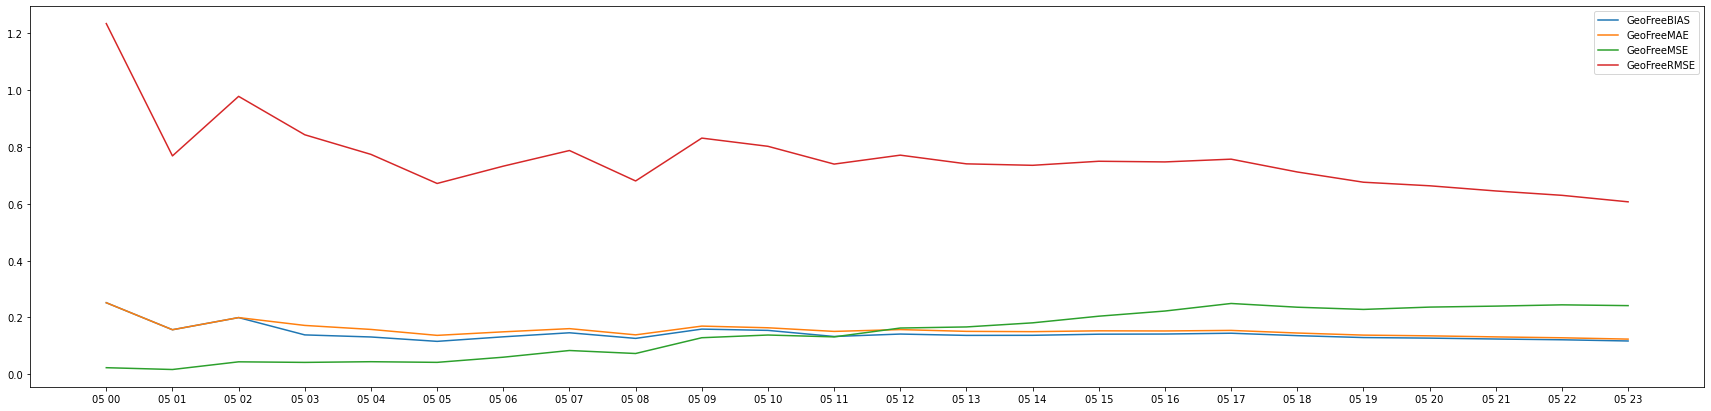

NBIAS:  0.11729056056264602
NMAE:  0.12385696811154638
NMSE:  0.2416521192959383
NRMSE:  0.6067727459229121


In [157]:
GeoFree_errors = Evaluation(df_evl[["TIME_CET", "VAERDI", "pred"]])
print("NBIAS: ", GeoFree_errors["NBIAS"].iloc[-1])
print("NMAE: ", GeoFree_errors["NMAE"].iloc[-1])
print("NMSE: ", GeoFree_errors["NMSE"].iloc[-1])
print("NRMSE: ", GeoFree_errors["NRMSE"].iloc[-1])
# print("R^2 Score: ", errors["GeoFree_R^2"].iloc[-1])

In [130]:
(1 - abs(errors["VAERDI"] - errors["pred"])/errors["VAERDI"]) * 100

0     74.815448
1     95.202399
2     72.939939
3     92.482551
4     89.737542
5     94.345328
6     78.927893
7     78.413638
8     98.885945
9     65.733008
10    87.495207
11    95.485222
12    79.606741
13    90.570174
14    86.024803
15    81.338550
16    85.245494
17    82.370875
18    98.415418
19    96.280907
20    89.864066
21    91.948292
22    91.689097
23    94.834356
dtype: float64

# Prediction NN - Geo

In [158]:
cols = ['hws_u_rn','hws_v_rn','hws_uv_rn','hws_uv_rn^2','hws_uv_rn^3','htmp_exp', 'Slope', 'Aspect',
'hws_uv_rn_q0.1','hws_uv_rn_q0.3','hws_uv_rn_q0.5','hws_uv_rn_q0.7','hws_uv_rn_q0.9',
'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']

In [132]:
model_geo = MLP(
  input_size=49,
  hidden_size=1000,
  output_size=1
)
model_geo, train_hist_geo, test_hist_geo = timeseries_kfold_validation_training(df=df_train, features=cols, target=["VAERDI"], n_groups=5, model=model_geo, lr=0.001, num_epochs=30)

Epoch 0 train loss: 0.09022177755832672 test loss: 0.07261050492525101
Epoch 10 train loss: 0.03212147206068039 test loss: 0.02779015153646469
Epoch 20 train loss: 0.022712979465723038 test loss: 0.021958231925964355
Epoch 29 train loss: 0.016466548666357994 test loss: 0.014162101782858372
Epoch 0 train loss: 0.014897638000547886 test loss: 0.015487361699342728
Epoch 10 train loss: 0.011403897777199745 test loss: 0.0110662542283535
Epoch 20 train loss: 0.010142275132238865 test loss: 0.010061887092888355
Epoch 29 train loss: 0.009603425860404968 test loss: 0.010280167683959007
Epoch 0 train loss: 0.009970889426767826 test loss: 0.010758783668279648
Epoch 10 train loss: 0.00915753934532404 test loss: 0.006983764469623566
Epoch 20 train loss: 0.008523720316588879 test loss: 0.007281860802322626
Epoch 29 train loss: 0.008332121185958385 test loss: 0.007063915021717548
Epoch 0 train loss: 0.007983018644154072 test loss: 0.007581951096653938
Epoch 10 train loss: 0.008035039529204369 test lo

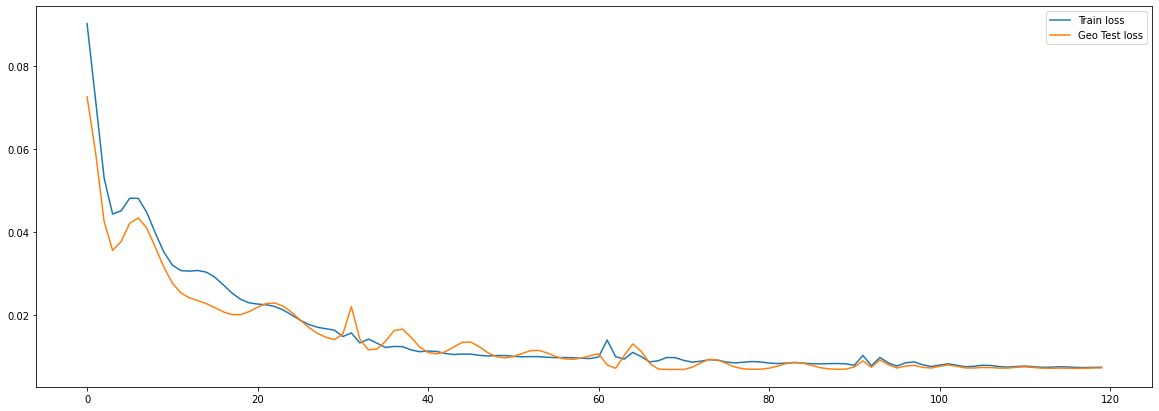

In [133]:
myplot.Model_Loss({"Train loss":train_hist_geo, "Geo Test loss": test_hist_geo})

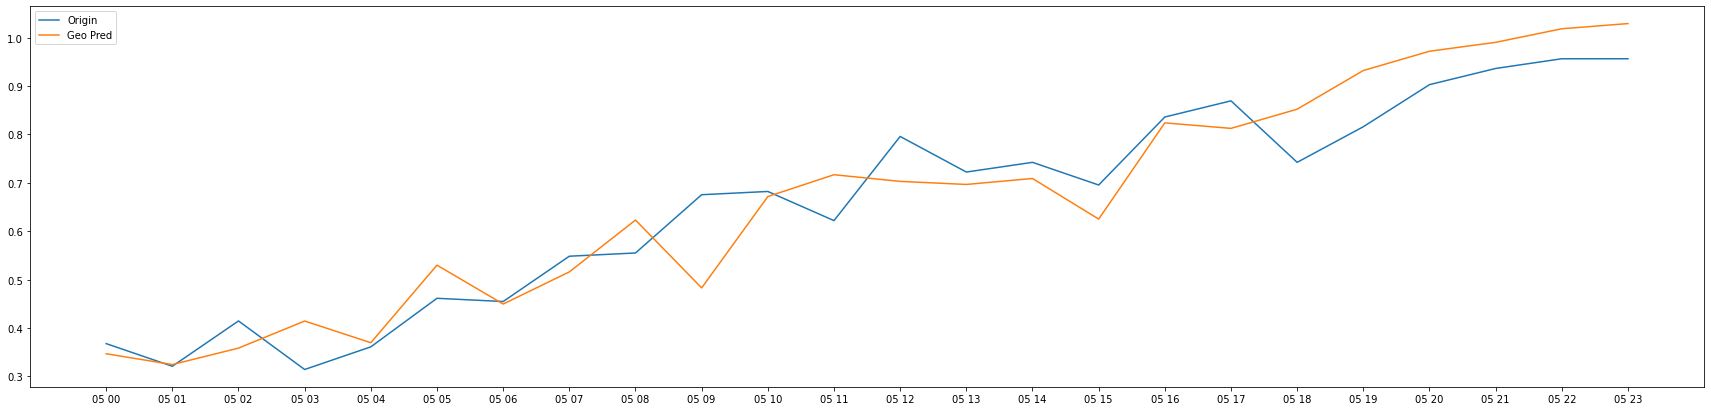

In [159]:
x_test_tensor = torch.tensor(df_evl[cols].values, dtype = torch.float)
y_pred_tensor = model_geo(x_test_tensor)
df_evl["pred"] = y_pred_tensor.detach().flatten().numpy()
myplot.timelines_plot(df_evl["TIME_CET"], {"Origin": df_evl["VAERDI"], "Geo Pred":df_evl["pred"]})

### Evaluation

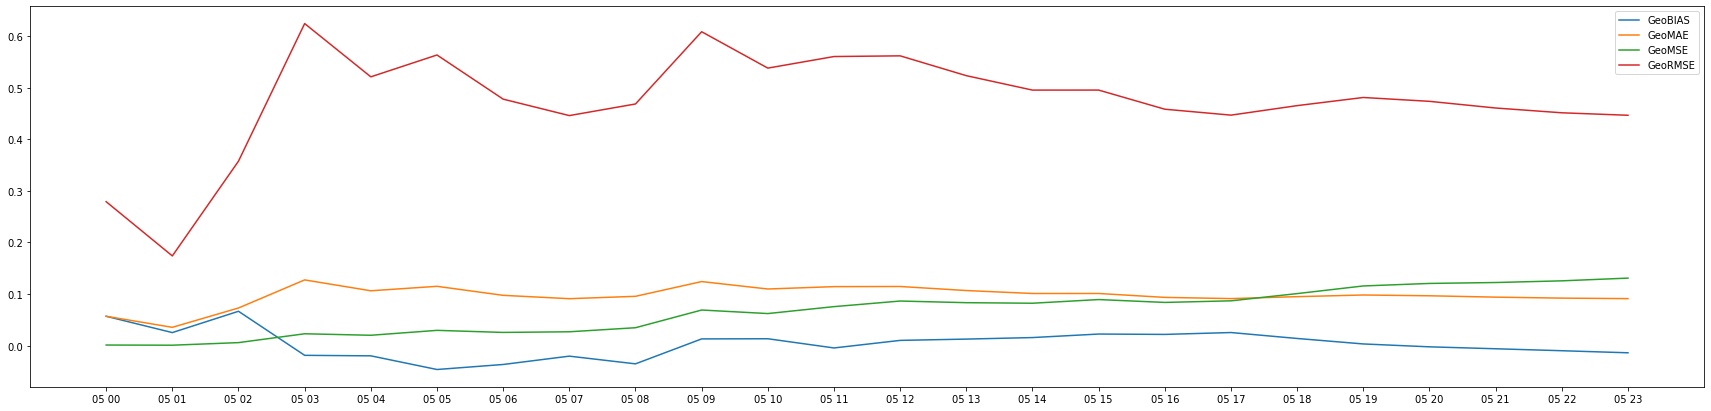

BIAS:  -0.013844929202093955
MAE:  0.09117424031225231
MSE:  0.13094653937990616
RMSE:  0.4466607329018212
R^2 Score:  0.8716687112754806


In [161]:
Geo_errors = Evaluation(df_evl[["TIME_CET", "VAERDI", "pred"]])
print("BIAS: ", Geo_errors["NBIAS"].iloc[-1])
print("MAE: ", Geo_errors["NMAE"].iloc[-1])
print("MSE: ", Geo_errors["NMSE"].iloc[-1])
print("RMSE: ", Geo_errors["NRMSE"].iloc[-1])
print("R^2 Score: ", Geo_errors["R^2"].iloc[-1])

In [136]:
(1 - abs(errors["VAERDI"] - errors["pred"])/errors["VAERDI"]) * 100

0     94.302813
1     98.907203
2     86.468797
3     68.138841
4     97.637330
5     85.161623
6     98.854193
7     94.093470
8     87.750569
9     71.496548
10    98.459346
11    84.760261
12    88.333090
13    96.454037
14    95.501274
15    89.876326
16    98.555041
17    93.455123
18    85.208670
19    85.764868
20    92.356495
21    94.234685
22    93.522115
23    92.400215
dtype: float64

In [165]:
100 * (GeoFree_errors["NMAE"] - Geo_errors["NMAE"]) / GeoFree_errors["NMAE"]

0     77.378246
1     77.355973
2     63.417066
3     25.895402
4     32.634435
5     16.057757
6     34.732178
7     43.341041
8     31.113315
9     26.753632
10    32.910007
11    24.203142
12    27.119054
13    29.298062
14    32.609779
15    33.886270
16    38.645783
17    40.948298
18    34.617070
19    28.797750
20    28.577268
21    28.569782
22    28.297466
23    26.387476
dtype: float64

In [166]:
(GeoFree_errors["GeoFree_NMSE"] - Geo_errors["Geo_NMSE"]) / GeoFree_errors["NMSE"]

0     0.948826
1     0.948725
2     0.866169
3     0.450851
4     0.546188
5     0.295370
6     0.574011
7     0.678976
8     0.525462
9     0.463497
10    0.549893
11    0.425484
12    0.468837
13    0.500124
14    0.545856
15    0.562897
16    0.623566
17    0.651290
18    0.572507
19    0.493024
20    0.489879
21    0.489772
22    0.485875
23    0.458120
dtype: float64